## Deps

In [1]:
# !pip install torch tqdm scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from IPython.display import display, Markdown

import torch
from torch import nn

import sys

sys.path.append("../")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/nacho/Desktop/code/ia_neuro/.conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/nacho/Desktop/code/ia_neuro/.conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/nacho/Desktop/code/ia_neuro/.conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/nacho/Desktop/code/ia_neuro/.conda/lib/python3.10/site-packages/traitlets/con

## Dataset

In [2]:
ds = pd.read_csv("dataset.csv")

ds = ds[ds["target"] != 0]

ds["date"] = pd.to_datetime(ds["date"])
dates = ds["date"]
date_2_3 = dates.mean() + 2 / 3 * dates.std()
date_2_3, dates.max(), dates.min(), dates.mean(), dates.std()

(Timestamp('2013-02-24 14:21:30.714119313'),
 Timestamp('2013-05-19 00:00:00'),
 Timestamp('2012-08-18 00:00:00'),
 Timestamp('2013-01-02 12:07:47.759788544'),
 Timedelta('79 days 15:20:34.431496154'))

<Axes: >

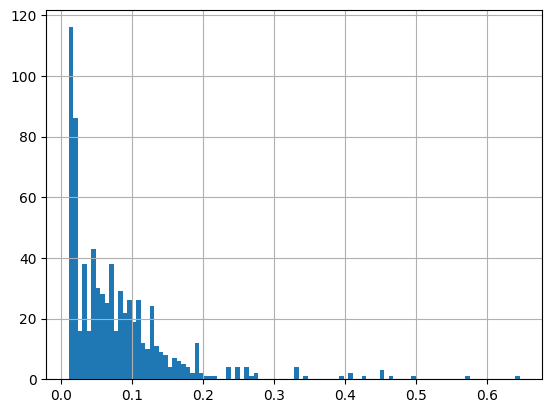

In [3]:
# For a sample player_1 in ds, plot target distribution
players_ocurrences = ds["player_1"].value_counts().sort_values(ascending=False)
sample_player = players_ocurrences.index[0]

sample_player_ds = ds[ds["player_1"] == sample_player]
sample_player_ds["target"].hist(bins=100)


(82550, 33448, 0.7116502008655322, 0.28834979913446784)

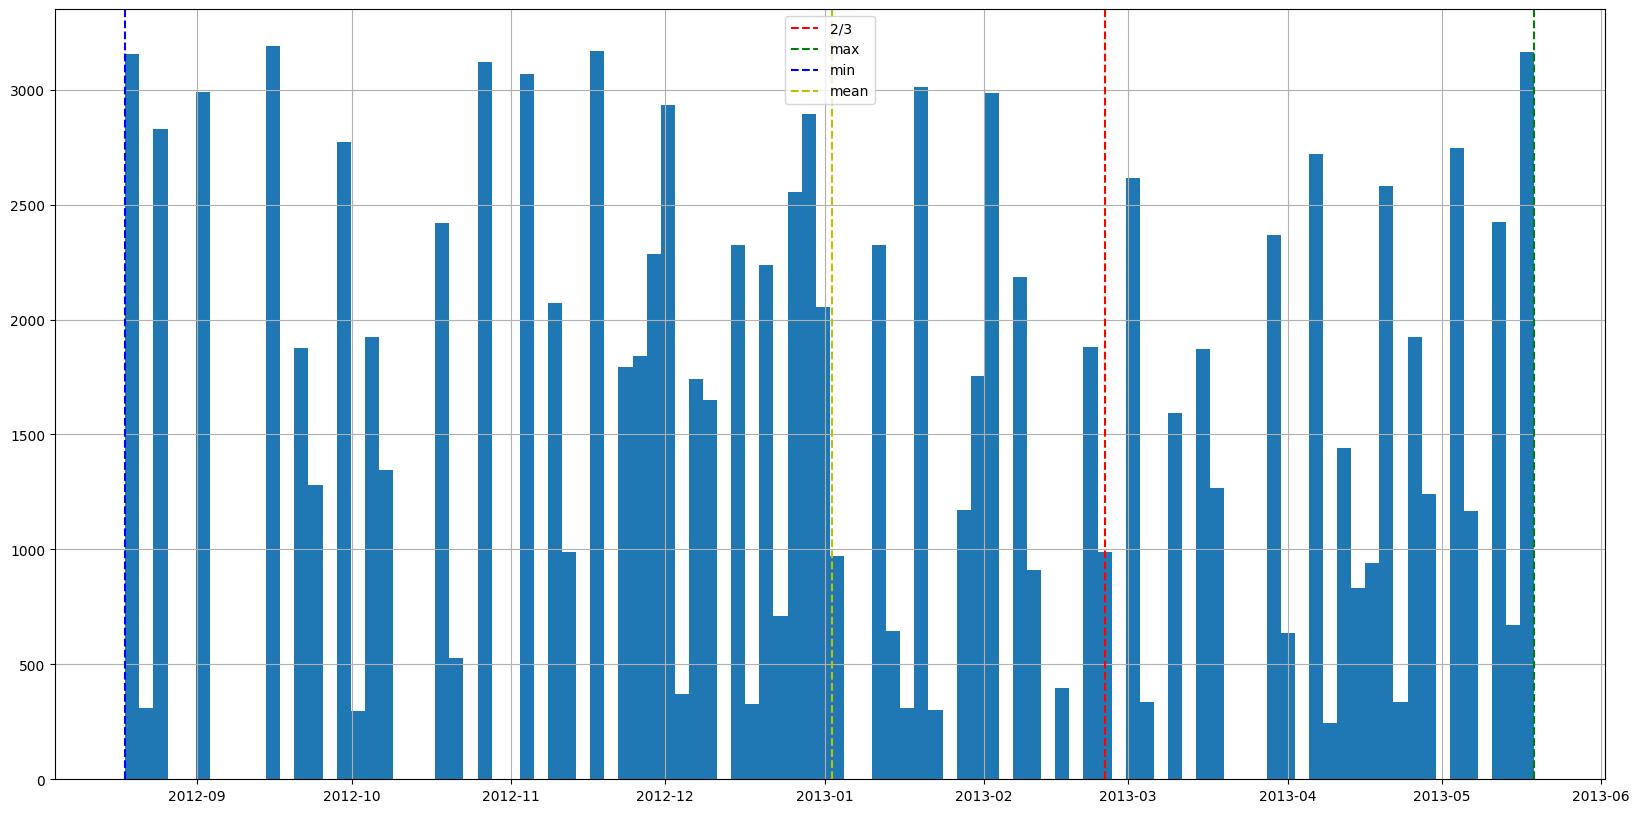

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
dates.hist(bins=100, ax=ax)

# Plot lines for date_2_3, dates.max(), dates.min(), dates.mean()
ax.axvline(date_2_3, color="r", linestyle="--", label="2/3")
ax.axvline(dates.max(), color="g", linestyle="--", label="max")
ax.axvline(dates.min(), color="b", linestyle="--", label="min")
ax.axvline(dates.mean(), color="y", linestyle="--", label="mean")

ax.legend()

left_c = ds[ds["date"] < date_2_3].shape[0]
right_c = ds[ds["date"] >= date_2_3].shape[0]

left_c, right_c, left_c / (right_c + left_c), right_c / (right_c + left_c)

In [5]:
# Select pairs of player_1 and player_2 that appear in the dataset
# Keep them in a test set

pairs = ds[["player_1", "player_2"]].drop_duplicates()
sample_pairs = pairs.sample(100)

test = ds[
    ds["player_1"].isin(sample_pairs["player_1"])
    & ds["player_2"].isin(sample_pairs["player_2"])
]

# train = ds[
#     ~ds["player_1"].isin(sample_pairs["player_1"])
#     | ~ds["player_2"].isin(sample_pairs["player_2"])
#     | ~ds["player_1"].isin(sample_pairs["player_2"])
#     | ~ds["player_2"].isin(sample_pairs["player_1"])
# ]

train = ds[ds["date"] < date_2_3]
train_left = train[train["date"] < date_2_3]

test_right = test[test["date"] >= date_2_3]

In [6]:
X_train = train_left.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_train = train_left["target"]

X_test = test_right.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_test = test_right["target"]

## Model

In [7]:
# device = "cpu"

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Using mps device


In [8]:
inputs = torch.tensor(X_train.loc[0])
labels = torch.tensor(y_train.loc[0])

inputs, labels

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_63665/1682424614.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(X_train.loc[0])


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor(0.0806))

In [13]:
# Train the model
# StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

model = NeuralNetwork().to(device)

Scaler = MinMaxScaler

X_scaler = Scaler()
y_scaler = Scaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train_scaled = pd.Series(y_train_scaled.flatten())

loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Convert the entire dataset to tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)


def train(X_train, y_train, model, loss_fn, optimizer, epochs):
    """
    Train a model using the given data

    Args:
        X_train (torch.Tensor): The training data
        y_train (torch.Tensor): The target data
        model (torch.nn.Module): The model to train
        loss_fn (torch.nn.Module): The loss function to use
        optimizer (torch.optim.Optimizer): The optimizer to use
        epochs (int): The number of epochs to train the model
    """
    iterator = tqdm(range(epochs * len(X_train)), desc="Training")
    for t in iterator:
        i = t % len(X_train)

        inputs = X_train[i]
        labels = y_train[i].unsqueeze(0)  # Ajustar tamaño

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        if i == 0:
            epoch_losses = []
            epoch_scores = []

        epoch_losses.append(loss.item())
        epoch_scores.append(model(inputs).item())

        mean_loss = np.mean(epoch_losses)
        mean_score = np.mean(epoch_scores)

        if t % len(X_train) == 0:
            iterator.set_postfix(
                {
                    "\tEpoch": t // len(X_train) + 1,
                    "\tLoss": mean_loss,
                    "\tScore": mean_score,
                }
            )


train(
    X_train_tensor,
    y_train_tensor,
    model,
    loss_fn,
    optimizer,
    epochs=10,
)

Training:   6%|▌         | 46046/825500 [05:49<1:38:41, 131.63it/s, 	Epoch=1, 	Loss=0.00507, 	Score=0.0807]    


KeyboardInterrupt: 

Score: 10.3219633102417 - MSE: 806.3551779859515

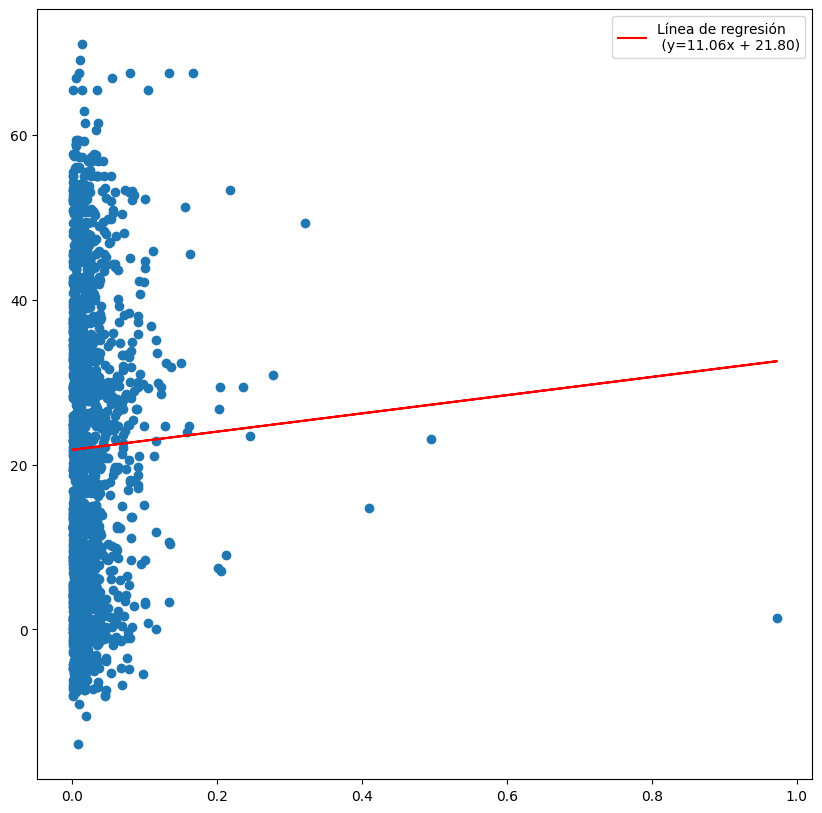

In [14]:
model.to(device)

# Convert the entire test dataset to tensors and move to device
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Evaluate the model
y_pred = []

for i in range(len(X_test_tensor)):
    inputs = X_test_tensor[i]
    y_pred.append(model(inputs).item())

y_pred = np.array(y_pred)

# y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

sc = model(inputs).item()
mse = mean_squared_error(y_test_scaled, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_test_scaled, y_pred)

# Plot regression line
reg = LinearRegression().fit(np.array(y_test_scaled).reshape(-1, 1), y_pred)
y_pred_line = reg.predict(np.array(y_test_scaled).reshape(-1, 1))
q_slope = reg.coef_[0]
q_intercept = reg.intercept_

# Dibujar la línea de regresión
ax.plot(
    y_test_scaled,
    y_pred_line,
    color="red",
    label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})",
)

ax.legend()

In [18]:
class ProbLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        distribution="uniform",
        init_type="fan_in",
        device=None,
        dtype=torch.float32,
        **kwargs,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        #
        # epsilon added to 'var' so that scale is always > 0 or that high > low
        self.eps = torch.tensor([1e-6])
        self.distribution = distribution
        self.in_features = in_features
        self.out_features = out_features
        assert self.distribution.upper() in [
            "UNIFORM",
            "NORMAL",
        ], f"Distribution must be one of: ['uniform', 'normal']. Not: {self.distribution}"

        if init_type.upper() == "FAN_OUT":
            kaiming_scale = torch.Tensor([np.sqrt(6 / out_features)]).type(
                torch.float32
            )
        else:
            kaiming_scale = torch.Tensor([np.sqrt(6 / in_features)]).type(torch.float32)

        self.w_val = torch.nn.parameter.Parameter(
            torch.randn((out_features, in_features), **factory_kwargs) * kaiming_scale,
            requires_grad=True,
        )
        self.w_var = torch.nn.parameter.Parameter(
            torch.ones_like(self.w_val, **factory_kwargs) * kaiming_scale,
            requires_grad=True,
        )

        if bias:
            self.b_val = torch.nn.parameter.Parameter(
                torch.randn((out_features), **factory_kwargs) * kaiming_scale,
                requires_grad=True,
            )
            self.b_var = torch.nn.parameter.Parameter(
                torch.ones_like(self.b_val, **factory_kwargs) * kaiming_scale,
                requires_grad=True,
            )
        else:
            self.b_val = self.register_parameter("b_val", None)
            self.b_var = self.register_parameter("b_var", None)

    def forward(self, x: torch.Tensor):
        #
        # We draw a new set of weight/bias each time the forward call is made.
        #   - I am using torch.abs() and a small epsilon in order to insure
        #     scale is always positive or that high > low.  There may be a
        #     much better way to go about this.
        if self.distribution.upper() == "UNIFORM":
            weight = torch.distributions.Uniform(
                low=self.w_val - torch.abs(self.w_var),
                high=self.w_val + torch.abs(self.w_var) + self.eps.to(x.device),
            ).rsample()
            bias = (
                torch.distributions.Uniform(
                    low=self.b_val - torch.abs(self.b_var),
                    high=self.b_val + torch.abs(self.b_var) + self.eps.to(x.device),
                ).rsample()
                if self.b_val is not None
                else 0.0
            )
        elif self.distribution.upper() == "NORMAL":
            weight = torch.distributions.Normal(
                loc=self.w_val, scale=torch.abs(self.w_var) + self.eps.to(x.device)
            ).rsample()
            bias = (
                torch.distributions.Normal(
                    loc=self.b_val, scale=torch.abs(self.b_var) + self.eps.to(x.device)
                ).rsample()
                if self.b_val is not None
                else 0.0
            )

        return x @ weight.T + bias

    #
    # Provide a little more information when this instance is printed
    def extra_repr(self) -> str:
        bias = self.b_val is not None
        return " in_features={}, out_features={}, bias={}, prob_distribution={}, device={}".format(
            self.in_features,
            self.out_features,
            bias,
            self.distribution.upper(),
            self.device,
        )

    #
    # So that we can determine which device this is set to
    @property
    def device(self):
        return next(self.parameters()).device

pnet = torch.nn.Sequential(ProbLinear(10, 100), torch.nn.Tanh(), ProbLinear(100, 1)).to(device)

# Train the model
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

train(
    X_train_tensor,
    y_train_tensor,
    model,
    loss_fn,
    optimizer,
    epochs=10,
)

Sequential(
  (0): ProbLinear( in_features=10, out_features=100, bias=True, prob_distribution=UNIFORM, device=cpu)
  (1): Tanh()
  (2): ProbLinear( in_features=100, out_features=1, bias=True, prob_distribution=UNIFORM, device=cpu)
)


Training: 100%|██████████| 825500/825500 [9:05:26<00:00, 25.22it/s, 	Epoch=10, 	Loss=0.000201, 	Score=-0.0532]     


In [19]:
# Save the model
torch.save(model.state_dict(), "model.pth")

Score: -0.8603793382644653 - MSE: 10.13903312467925

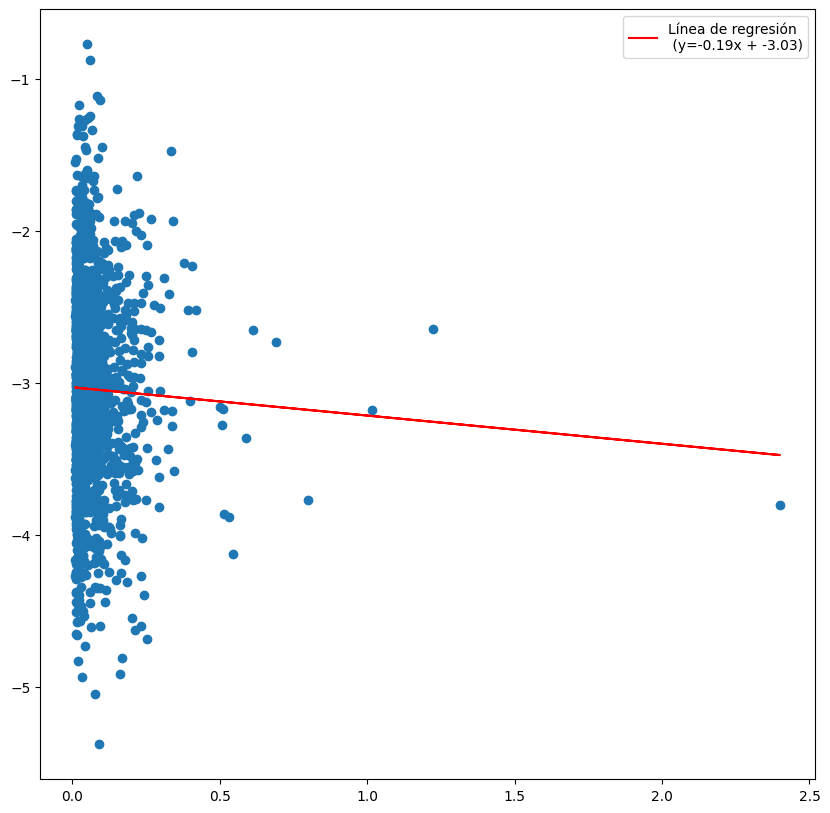

In [21]:
# Evaluate the model

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

y_pred = []

for i in range(len(X_test_tensor)):
    inputs = X_test_tensor[i]
    y_pred.append(model(inputs).item())

y_pred = np.array(y_pred)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

sc = model(inputs).item()
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_test, y_pred)

# Plot regression line
reg = LinearRegression().fit(np.array(y_test).reshape(-1, 1), y_pred)

y_pred_line = reg.predict(np.array(y_test).reshape(-1, 1))
q_slope = reg.coef_[0]
q_intercept = reg.intercept_

# Dibujar la línea de regresión
ax.plot(
    y_test,
    y_pred_line,
    color="red",
    label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})",
)

ax.legend()